# Training Models

## Linear Regression

In this section we'll be focused on the linear model $y = h_{\theta}(\mathbf{x}) = \theta^T\mathbf{x}$. We'll be focused on two different ways to train the model to arrive at $\hat{\theta}$. The most popular method is the MLE which minimizes MSE
<center>
$\hat{\theta} = \arg\min \frac{1}{m}\sum_{i=1}^m(y_i - \theta^T\mathbf{x}_i)^T$
</center>
This of course has the OLS solution given by $\hat{\theta}_{OLS} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$.

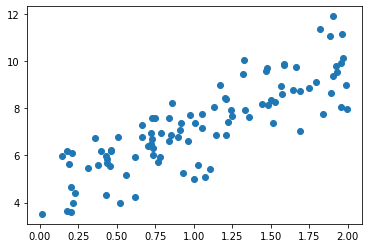

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
plt.scatter(X, y)

In [2]:
X_b = np.c_[np.ones((100, 1)), X]
theta_ols = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [3]:
theta_ols

array([[4.41931532],
       [2.73577588]])

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_ols)

In [5]:
y_predict

array([[4.41931532],
       [9.89086708]])

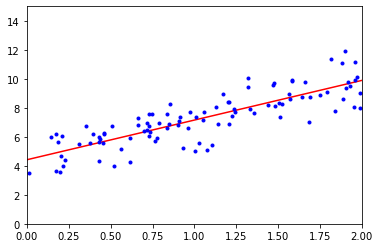

In [6]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
#directly from sklearn 
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.41931532]), array([[2.73577588]]))

In [8]:
lin_reg.predict(X_new)

array([[4.41931532],
       [9.89086708]])

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond = 1e-6)
theta_best_svd # the psuedo inverse of X times y $X^{\dagger}y$

array([[4.41931532],
       [2.73577588]])

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.41931532],
       [2.73577588]])

It may be better to work directly with the psuedo inverse because of rank problems in the normal equations. 

Computational Complexity: Inverting $X^TX$ takes $O(n^{2.4})$ time while the psudo inverse scales like $O(n^2)$ where $n$ denotes the number of features. It scales linearly in the number of instances $O(m)$ so, provided the dataset can fit into memory, it scales well with the training set size.

## Gradient Descent 

This is a much different way to fit $h_{\theta}(\cdot)$ that scaled better with the number of features $n$ and when the training set of size $m$ cannot fit into memory. Here we trade off exactly optimal OLS solutions for computation feasibility.

The idea is to start with a random initialization of the parameter vector $\theta_0$ then iteratively tweek $\theta_t = \theta_{t-1} -\eta\nabla_{\theta}(f(\theta_{t-1}))$ to decrease the loss function $f(\cdot)$.

In order to implement GD, you need to find the gradient of the cost function with respect to $\theta$, $\nabla_{\theta}(\text{f}(\theta))$. If we take MSE as the cost function the $j$-th partial derivative is given by 
<center>
    $\frac{\partial}{\partial \theta_j}\text{MSE}(\theta) = \frac{2}{m}\sum_{i=1}^m(\theta^T\mathbf{x}_i - y_i)\mathbf{x}_{ij}$
</center>

Writting this in in vector form we have
<center>
    $\nabla_{\theta}\text{MSE}(\theta) = \frac{2}{m}\mathbf{X}^T(\mathbf{X}\theta - \mathbf{y})$
</center>
This algorithm is called Batch Gradient Descent because it requires the _full_ 'batch' of training data in each calculation of $\nabla_{\theta}\text{MSE}(\theta)$. It is very slow of large training sets ($m$) but scales well with the number of features ($n$).  

With this the update can be written as 

<center>
    $\theta_{t} = \theta_{t-1} - \eta \frac{2}{m}\mathbf{X}^T(\mathbf{X}\theta_{t-1} - \mathbf{y})$
</center>


In [11]:
#quick implementation
eta = 0.1 
n_iter = 1000
m = 100
#GD with MSE
theta = np.random.randn(2, 1)
for iter in range(n_iter):
    theta = theta - eta * 2/m * X_b.T.dot(X_b.dot(theta) - y)

In [12]:
theta, theta_ols #notice these are the same

(array([[4.41931532],
        [2.73577588]]),
 array([[4.41931532],
        [2.73577588]]))

Convergence Rate: if the cost is convex and second order derivative is smooth, then the rate coverges like $O(1/\epsilon)$ where $\epsilon$ is the user chosen tolerance.

## Stochastic Gradient Descent

Standard gradient descent uses the entire training set to calcualte the gradients. Stochastic gradient descent only uses one training instance toe calculate the gradient. The algorithm will bounce around due to this bias, but this could be a good thing with non-convex cost function. The randomness could be bad because it will never truly converge. 

One idea is to gradually reduce the learning rate. This idea is _simulated annealing_ and the function that determines the learning rate is called the _learning schedule_. 

In [13]:
# basic implementation for MSE loss 
n_epochs = 50
t0, t1 = 5, 50 #hyper parameters
def learning_schedule(t):
    return t0/(t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch*m + i)
        theta = theta - eta*gradients

#print results
theta

array([[4.42160837],
       [2.66178251]])

Instead of randomly choosing each instance, you can also shuffled the data, and scan the data to ensure that each point is used in calculating a gradient. This approach in general converges more slowly. 

To complete SGD Linaer Regression using sklearn, we use the *SGDRegressor* class. 

In [14]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = .1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [15]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.42765417]), array([2.72538047]))

## Mini-batch Gradient Descent

Mini-batch gradient descent calculates the gradients based on subsets of the training data called _mini-batches_. The main advatange of this method is you get performance boost from optimization in matrix multiplication so it runs quicker than GD, enjoys the stochastic nature of SGD, but with less variance.

## Polynomial Regression

In this section we'll be foucsed on polynomial regression fit with the same (S)GD methods.

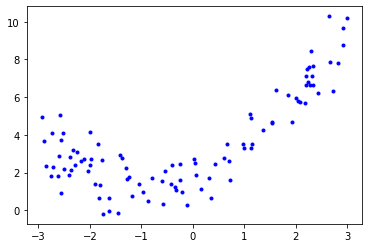

In [16]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
plt.plot(X, y, 'b.')

We can use sklearn to generate polynomial features then pass them to the LinearRegression class to fit via SVD.

In [17]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([1.13392593]), array([1.13392593, 1.28578802]))

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.8115289]), array([[0.98231086, 0.54928671]]))

Note: _PolynomialFeatures(degree = d)_ includes all cross terms as well upto degree $d$. So it includes the all terms in $(a+b)^d$. 

## Learning Curves

Learning curves are a visual tool to assess if a model is under/overfitting the data. Plots the models performance on the training and validation set for increasing size of the training data. 

In [19]:
#create learning curve function
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 

np.random.seed(1985)

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [],[]
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth = 2, label = 'train')
    plt.plot(np.sqrt(val_errors), 'b-+', linewidth = 3, label = 'val')
    plt.legend(loc="upper right")   
    plt.xlabel("Training set size") 
    plt.ylabel("RMSE")              
        

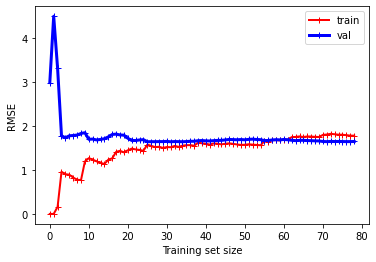

In [20]:
#Test on linear regression model
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

When both curves plateau and are fairly high is a sign of underfitting. 

(0.0, 80.0, 0.0, 3.0)

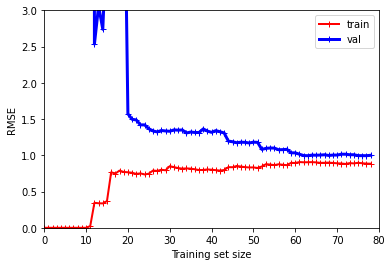

In [21]:
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree = 10, include_bias = False)), 
    ('lin_reg', LinearRegression())
])
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3]) 

First notice that the training error is much lower than the linear model. Also notice the gap between the two lines suggesting poor generalization - i.e. overfitting. 

## Regularized Linear Models

Ridge regression adds regularization by adding in an $\ell_2$ penalty if $\alpha\|\theta\|_2^2$. 
<center>
    $J(\theta) = \text{MSE}(\theta) + \frac{\alpha}{2}\|\theta\|_2^2$
</center>
Note: The penalty turn should only be used in training. You want to use unregularized measures of fit for the validation set. 
Note: We rarely regularize $\theta_0$. For ease of notation, we'll assume that $\theta = (\theta_1, \ldots, \theta_n)^T$. 
With this loss function, in training we just add $\alpha\|\theta\|_2$ to the SDG update. Ridge also have a closed form solution given by
<center>
    $\hat{\theta} = (\mathbf{X}^T\mathbf{X} + \alpha\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$
</center>


In [22]:
#Ridge fit with closed form solution
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.14513327]])

In [23]:
#Ridge fit with SGD 
sgd_reg = SGDRegressor(penalty ='l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])


array([5.14113205])

Lasso regrssion is another approach to regularization using an $\ell_1$ penalty $\alpha\|\theta\|_1$. 
<center>
    $J(\theta) = \text{MSE}(\theta) + \alpha\|\theta\|_1$
</center>
Then central difference between ridge and lasso is that lasso can acuatally set values to zero.
Since $J(\theta)$ is non-differential, we rely on _subgradient_ vectors to carry out the SGD. In particular
<center>
    $g(\theta, J) = \nabla_{\theta}\text{MSE}(\theta) + \alpha[\text{sgn}(\theta_i)]_{i=1}^n$
</center>
where we can write $sng(\theta)$ as 
<center>
    $sgn(\theta) = \begin{cases}
    -1 & \theta < 0 \\ 
    0 & \theta = 0\\
    1 & \theta > 0
    \end{cases}$
</center>

In [24]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.10094179])

Finally, we can combine lasso and ridge to complete _elastic net_ regression. 
<center>
    $J(\theta) = \text{MSE}(\theta) + r\alpha\|\theta\|_1 + \frac{1-r}{2}\alpha\|\theta\|_2^2$
</center>
Why? When $p > n$ lasso can behave erratically. So elastic net helps by centering the solution around the ridge solution.

In [25]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.10282739])

## Early Stopping

Another way to induce regularization is to simply stop SGD when the validation error hits a minimum. This approach is called _early stopping_.

In [26]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

#prep data 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree = 90, include_bias = False)),
    ('std_scaler', StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

#set up model
sgd_reg = SGDRegressor(max_iter = 1, tol = -np.infty, warm_start = True, 
                       penalty = None, learning_rate = 'constant', eta0 = 0.0005)

#early stopping alg 
minimum_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel()) #saves the current state at every epoch due to warm_start = True
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

## Logistic Regression



In logistic regression we focus on modeling the log-odds relating the response to the covariates via a logistic link.
<center>
    $\hat{p} = h_{\theta}(\mathbf{x}) = \frac{1}{1 + \exp(-\mathbf{x}^T\theta)}$
</center>
Classification is then completed via the thresholding 
<center>
    $\hat{y} = \begin{cases}
    1 & \hat{p} < 0.5 \\ 0 & \hat{p} \geq 0.5
    \end{cases}$
</center>
We fit $h_{\theta}(\cdot)$ by MLE which correpsonds to the cost function
<center>
    $c(\theta) = \begin{cases}-\log(\hat{p}) & y = 1\\ -\log(1-\hat{p}) & y = 0 \end{cases}$.
</center>
With this we can write the full log-loss as 
<center>
    $J(\theta) = -\frac{1}{m}\sum_{i=1}^m\left(y_i\log(\hat{p}_i) + (1-y_i)\log(1-\hat{p}_i)\right)$
</center>
$J(\theta)$ has no closed form solution but is convex so any SGD or IRLS algorithm will converge to the global minimizers. The partial derivates used in these algorithms are given by 
<center>
    $\frac{\partial}{\partial \theta_j}J(\theta) = \frac{1}{m}\sum_{i=1}^m (\sigma(\theta^T\mathbf{x}_i) - y_i)x_{ij}$
</center>

In [28]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [32]:
X = iris['data'][:, 3:]
y = (iris['target'] == 2).astype(np.int) # Trying to classify iris virginica 

In [33]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

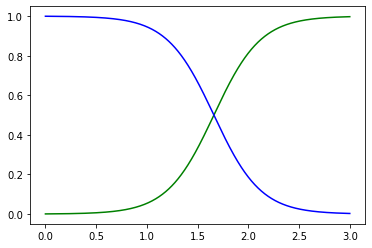

In [34]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], 'g-', label = 'Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b', label = 'Not Iris virginica')

In [35]:
log_reg.predict([[1.7] ,[1.5]])

array([1, 0])

Note: scikit automatically adds in $\ell_2$ regularization with parameter $c$ where $c\propto 1/\alpha$. That is higher values of $c$ correspond to _less_ regularization

## Softmax Regression

Softmax regression generalizes logistic regression to multiple classes. It first computes scores $$s_k(\mathbf{x}) =\mathbf{x}^T\theta^{(k)}$$. Notice that each class has its own parameter vector so $\Theta = [\theta^{(1)T}\dots \theta^{(K)T}]^T$ parameterizes the model. You can then find the estimated probabilities by running each score through the softmax function $$\hat{p}_k = \frac{\exp(s_k(\mathbf{x}))}{\sum_{k=1}^K\exp(s_k(\mathbf{x}))}$$.
Finally, class predictions are made via $\hat{y} = \arg\max_{k\in[K]} \hat{p}_k$. 

Training occurs by minimizing _cross entropy_ $$J(\theta) = -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^Ky_k^{(i)}\log(\hat{p}_k^{(i)})$$. The gradients for cross entropy cna be written as $$\nabla_{\theta^{(k)}}J(\theta) = \frac{1}{m}\sum_{i=1}^m(\hat{p}_k^{(i)} - y_k^{(i)})\mathbf{x}^{(i)}$$.

In [36]:
#fetch data and all targets
X = iris['data'][:,(2,3)]
y = iris['target']

#fit model
softmax_reg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C = 10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [38]:
softmax_reg.predict([[5,2]])

array([2])

In [39]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

## Exercises 

1. You should use SGD or mini-batch SGD. Using the SVD solution will scale like $O(p^3)$ where $p$ is the number of features so this will be untractable. SGD is more robust to large $p$ problems.
2. Gradient Descent algorithms suffer from this because the magnitude of the graidents are artifically inflated by feature magnitude. Exact solutions are robust to this. You can remedy these issues by standarizing the input variables. 
3. No - the logistic likelihood is convex. 
4. Not necessarily - e.g. nonconvexity, step sizes in SGD, etc.
5. Overfitting is probably happening. Try regularizing. (Solution suggests that the learning rate is too high). 
6. Early stopping suggests yes. But mini-batch GD means we could have not seen part of the data, so the model might be fitting to a new part of the data. So I would suggest to continue training. 
7. If fastest is runtime not number of iterations, SGD will reach it the fastest. GD will actually converge (assuming convexity) but be the slowest. SGD and mini-batch can converge if you include simulated annealing.
8. Overfitting. Reduce the degree of the polynomial as a form of regularization.
9. You're underfitting here. Reduce the learning parameter to fit the data more closely. We're suffering from high bias. 
10. 
    a. Control for outliers, better generalizations, stability.
    b. Feature selection.
    c. When p > n 
11. You should do two logistic regression models since there is overlap in the output categories (e.g. Daytime - Outdoors)
12. (Implement batch gradient descent with early stopping for softmax. )

In [154]:
#early stopping alg for mini-batch SGD for softmax 
minimum_val_error = float('inf')
best_epoch = None
best_model = None
batch_size = 25
batchs = np.shape(X)[0] // batch_size
theta = np.random.randn(3, 3)
n, m = np.shape(X)
ind = np.random.shuffle([x for x in range(np.shape(X)[0])])
X_shuffle = np.c_[np.ones(150), X[ind, :].reshape(150, 2)]
y_shuffle = y[ind].reshape(150,)
eta = 0.1

#this function comes from the solutions found here: https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb
#@author A. Geron 
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

for epoch in range(1000):
    for i in range(batchs):
        #get X and y for this batch
        X_batch = X_shuffle[(batch_size*i):(batch_size*(i+1)) , :]
        y_batch = y_shuffle[(batch_size*i):(batch_size*(i+1))]
        
        #fetch y_mat
        y_mat = to_one_hot(y_batch)
        print(np.shape(y_mat))
        
        #calculate p's
        sk = np.exp(X_batch @ theta)
        pk = sk / np.sum(sk, axis = 1)[:, None]
        
        #calculate gradients
        gradients = 1/m * X_batch.T.dot(pk - y_mat)
        
        #update theta
        theta -= eta * gradients
        
        
        #analyze for early stopping 

(25, 1)
(25, 1)
(25, 2)


ValueError: operands could not be broadcast together with shapes (25,3) (25,2) 

In [141]:
minimum_val_error = float('inf')
best_epoch = None
best_model = None
batch_size = 25
batchs = np.shape(X)[0] // batch_size
theta = np.random.randn(6, 1).reshape(2, 3)
n, m = np.shape(X)
ind = np.random.shuffle([x for x in range(np.shape(X)[0])])
X_shuffle = X[ind, :]
y_shuffle = y[ind]

In [145]:
np.shape(y_shuffle.reshape(150, ))

(150,)